# Kinase fold structural alignment

This notebook showcases alignment of kinases by the structure of their ATP-binding folds.

The user may select any two human kinases and their ATP-binding domains will be displayed with structures aligned and superimposed. Alignment is done by the TM-align algorithm.

For this visualization, we use high-confidence predicted structures from AlphaFold2 (https://alphafold.ebi.ac.uk/).

## Instructions

**Choose any two human kinases below by entering their Uniprot entry names.**

You may choose to display only the kinase domain (default) or the full proteins.

You may also choose the colors to display the proteins.

In [1]:
### choose proteins to align
### Note: for kinases with multiple ATP-binding domains, append "_1", "_2", etc. to align the specified domain
prot1 = "STK11_HUMAN"
prot2 = "GRK7_HUMAN"
### choose whether to use full proteins or pockets only
full_proteins = False
### choose colors for proteins
col1 = "cyan"
col2 = "yellow"

In [2]:
### Other examples
#prot1 = "PK3CA_HUMAN"
#prot2 = "PK3CB_HUMAN"
#prot1 = "MTOR_HUMAN"
#prot2 = "ATR_HUMAN"
#prot1 = "AKT1_HUMAN"
#prot2 = "AKT2_HUMAN"
#prot1 = "KS6A6_HUMAN_1"
#prot2 = "KS6A6_HUMAN_2"

### Install necessary Python packages

In [3]:
#!pip install biopython
#!pip install pyprojroot
#!pip install py3Dmol

### Load packages

In [4]:
from Bio.PDB import *
from pyprojroot import here
import os
#import nglview as nv
import py3Dmol
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

### Load necessary data files -- a pkl file of TM-align output and a CSV with kinase metadata

In [5]:
### load pkl file
pkl_file = os.path.join(here(), "data", "structures", "AF2_pocketome_tm_score.pkl")
f = open(pkl_file, "rb")
tmp = pickle.load(f)
f.close()

### load csv file with metadata
csv_file = os.path.join(here(), "data", "metadata", "kinome_plus_pocket_meta_2022_04_06.csv")
df = pd.read_csv(csv_file)

### Kinase metadata

In [6]:
### the column "uniprot_name_mod" contains uniprot entry names for all human kinases
### Note: kinases with multiple ATP-binding domains are listed multiple times here, with "_1", "_2", etc. appended.
df[['uniprot_name_mod', 'uniprot_accession', 'gene_names', 'protein_names', 'hgnc_symbol','is_idg_dark_kinase']]

,uniprot_name_mod,uniprot_accession,gene_names,protein_names,hgnc_symbol,is_idg_dark_kinase
0,AAK1_HUMAN,Q2M2I8,AAK1 KIAA1048,AP2-associated protein kinase 1 (EC 2.7.11.1) ...,AAK1,0
1,AAPK1_HUMAN,Q13131,PRKAA1 AMPK1,5'-AMP-activated protein kinase catalytic subu...,PRKAA1,0
2,AAPK2_HUMAN,P54646,PRKAA2 AMPK AMPK2,5'-AMP-activated protein kinase catalytic subu...,PRKAA2,0
3,ABL1_HUMAN,P00519,ABL1 ABL JTK7,Tyrosine-protein kinase ABL1 (EC 2.7.10.2) (Ab...,ABL1,0
4,ABL2_HUMAN,P42684,ABL2 ABLL ARG,Tyrosine-protein kinase ABL2 (EC 2.7.10.2) (Ab...,ABL2,0
...,...,...,...,...,...,...
705,WNK4_HUMAN,Q96J92,WNK4 PRKWNK4,Serine/threonine-protein kinase WNK4 (EC 2.7.1...,WNK4,0
706,XYLB_HUMAN,O75191,XYLB,Xylulose kinase (Xylulokinase) (EC 2.7.1.17),XYLB,0
707,XYLK_HUMAN,O75063,FAM20B KIAA0475,Glycosaminoglycan xylosylkinase (EC 2.7.1.-) (...,FAM20B,0
708,YES_HUMAN,P07947,YES1 YES,Tyrosine-protein kinase Yes (EC 2.7.10.2) (Pro...,YES1,0


### Helper functions

In [7]:
## function to take uniprot name and translate to the accession number
## @input uni_name - a uniprot name (i.e. "STK11_HUMAN") -- kinases with multiple ATP-binding domains will have "_1" or "_2" appended 
## @return the corresponding uniprot accession number -- again some will be appended with "_1" or "_2"
def uni_name_to_acc(uni_name):
    ind = np.where(df.uniprot_name_mod == uni_name)
    uni_acc = df.uniprot_accession_mod[int(ind[0])]
    return(uni_acc)

## function to take two proteins and get the TM-align rotation matrix + translation vector
## @input a,b - two uniprot accession numbers 
## @return u,t - a rotation matrix u and a translation vector t
def get_rot_mat(a,b):
    l1 = tmp['uni1']
    l2 = tmp['uni2']
    u_list = tmp['u']
    t_list = tmp['t']
    tm1 = tmp['tm1']
    tm2 = tmp['tm2']
    for i in range(0,len(l1)):
        if l1[i] == a and l2[i] == b:
            u = u_list[i]
            t = t_list[i]
            tm_1 = tm1[i]
            tm_2 = tm2[i]
            order = "same"
            return(u, t, tm_1, tm_2, order)
        if l1[i] == b and l2[i] == a:
            u = u_list[i]
            t = t_list[i]
            tm_1 = tm1[i]
            tm_2 = tm2[i]
            order = "reverse"
            return(u, t, tm_1, tm_2, order)
        ## if not found, return empty lists
    return([], [], [], [], [])

### Load and align kinase structures

In [8]:
acc1 = uni_name_to_acc(prot1)
acc2 = uni_name_to_acc(prot2)

#print(prot1 + ": " + acc1)
#print(prot2 + ": " + acc2)

if full_proteins:
    file1 = os.path.join(here(),"data", "structures", "AF2", "AF-" + acc1 + "-F1-model_v2.pdb")
    file2 = os.path.join(here(),"data", "structures", "AF2", "AF-" + acc2 + "-F1-model_v2.pdb")
else:
    file1 = os.path.join(here(),"data", "structures", "AF2_kinase_pockets", acc1 + "_pocket_only.pdb")
    file2 = os.path.join(here(),"data", "structures", "AF2_kinase_pockets", acc2 + "_pocket_only.pdb")

parser = PDBParser()
str1 = parser.get_structure(prot1, file1)
str1_orig = parser.get_structure(prot1, file1)
str2 = parser.get_structure(prot2, file2)
str2_orig = parser.get_structure(prot2, file2)

u,t,tm1,tm2,order = get_rot_mat(acc1, acc2)

if order == "same":
    str1.transform(u.T, t)
else:
    str2.transform(u.T, t)

tmp_f1 = os.path.join(here(), "temp", "str1.pdb")
tmp_f2 = os.path.join(here(), "temp", "str2.pdb")
io=PDBIO()
io.set_structure(str1)
io.save(tmp_f1)
io=PDBIO()
io.set_structure(str2)
io.save(tmp_f2)

### Kinase alignment visualization

The aligned kinases are displayed along with their TM-scores.
Note that the TM-score is normalized by the length of the reference protein, so there are two possible TM-scores -- both are displayed:

In [9]:
### print TM-score
print(prot1 + ": " + acc1)
print(prot2 + ": " + acc2)
print("TM-score 1: " + str( round(tm1, 2)) )
print("TM-score 2: " + str( round(tm2, 2)) )
### View protein overlays
view = py3Dmol.view()
view.addModel(open(tmp_f1, 'r').read(), 'pdb')
view.setStyle({'model': 0},{'cartoon':{'color':col1}})
view.addModel(open(tmp_f2, 'r').read(), 'pdb')
view.setStyle({'model': 1},{'cartoon':{'color':col2}})
view.zoomTo()
view.show()

STK11_HUMAN: Q15831
GRK7_HUMAN: Q8WTQ7
TM-score 1: 0.92
TM-score 2: 0.93


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Heatmap of TM-scores

This heatmap shows pairwise TM-scores of kinases.
Each TM-score is between 0 (no alignment) and 1 (perfect alignment) and 

C:\Users\NC168\Anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


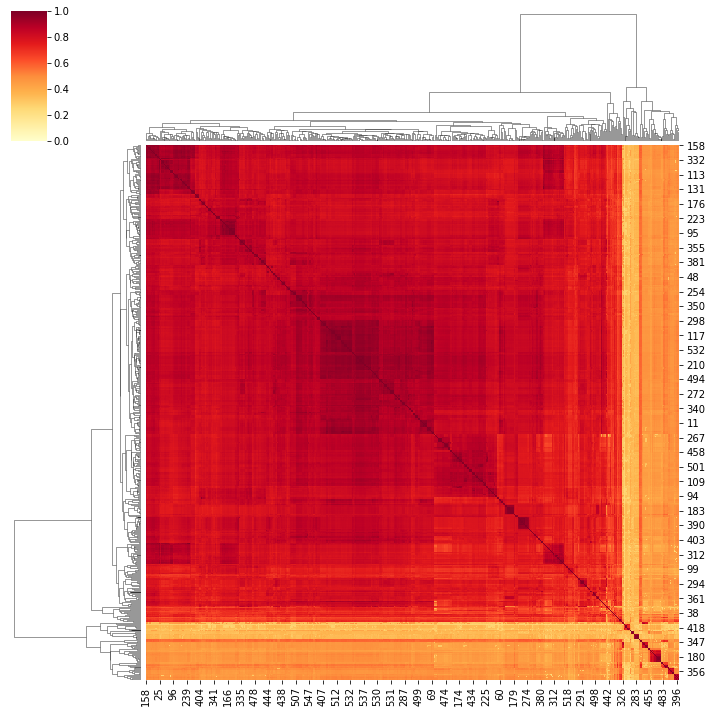

In [10]:
mat = tmp['tm_max_mat']
sns.clustermap(mat, cmap="YlOrRd", vmin=0, vmax=1)